# Galaxies: An interactive graduate course

## Chapter 2.4: SDSS: Luminosity functions

#### (c) Benedikt Diemer, University of Maryland (based on similar notebooks by Andrey Kravtsov, University of Chicago)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from routines import common as cmn

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Automatically reload code imported from changed python files
%reload_ext autoreload
%autoreload 2

### 2.4.1) Malmquist bias and the Vmax method

In [2]:
from routines import obs_sdss

data = obs_sdss.loadSdssSpecSampleExtra()

#### Quantifying Malmquist bias

Our goal for this notebook is to quantify the abundance of galaxies by luminosity (or magnitude), but we already know that we cannot simply take the distribution of magnitudes from our SDSS sample because they are strongly biased towards brighter galaxies the farther we go out. Let's quantify this bias a little more:

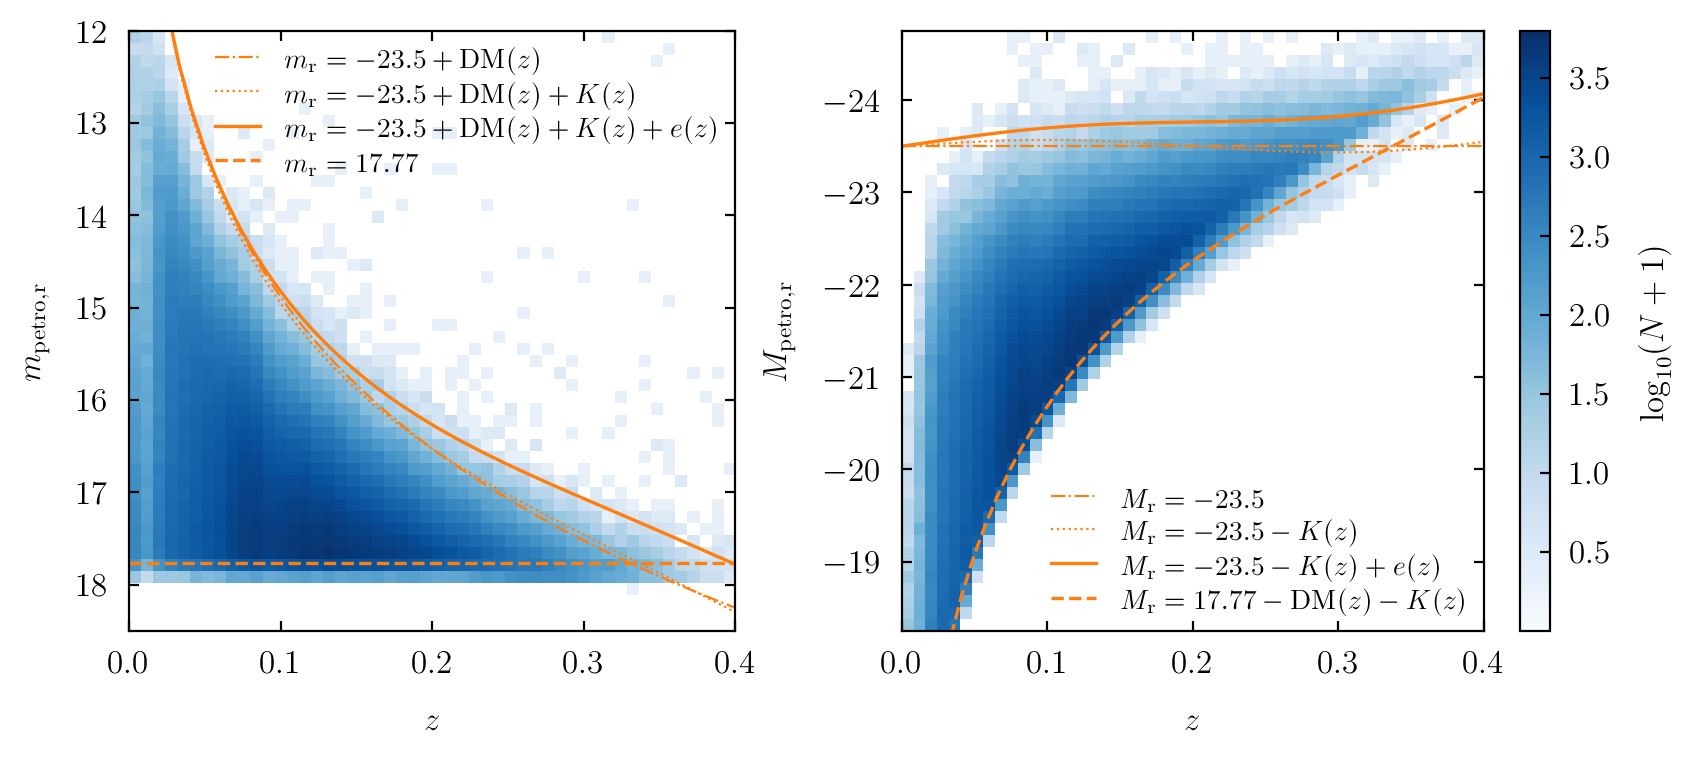

In [3]:
from routines import obs_utils

z_lo = 0.0
z_hi = 0.4
m_lo = 18.5
m_hi = 12.0

M_std = -23.5
m_lim = obs_sdss.m_r_limit
gr_std = 0.8

cmap = plt.get_cmap('Blues')
cmap.set_under('#FFFFFF')
cbar_limit = 3.8

# Compute apparent magnitude from a "standard candle" of fixed absolute magnitude. We 
# use the evolution correction of Bell et al. 2003, who suggested that absolute luminosities
# of galaxies were about 1.3z brighter in the past (in the r-band).
z_array = np.linspace(0.0001, z_hi, 50)
DM = cmn.cosmo.distanceModulus(z_array)
K = obs_utils.kCorrection('r', z_array, 'g-r', gr_std)
evo = -1.3 * z_array

# Plot
fig, axs = plt.subplots(1, 2, figsize = (10.0, 4.0), width_ratios = [1.0, 1.2])
plt.subplots_adjust(wspace = 0.25)

for i in range(2):

    # Plot twice for m and M
    if i == 0:
        y = data['m_petro_r']
        ylabel = r'$m_{\rm petro,r}$'
        y_lo = m_lo
        y_hi = m_hi
    else:
        y = data['M_petro_r']
        ylabel = r'$M_{\rm petro,r}$'
        max_dm = cmn.cosmo.distanceModulus(z_hi) - 5
        y_lo = m_lo - max_dm
        y_hi = m_hi - max_dm

    # Compute 2D histogram
    hist, _, _ = np.histogram2d(data['z'], y, bins = (50, 50), range = [[z_lo, z_hi], [y_hi, y_lo]])
    hist = np.log10(hist.T[::-1] + 1.0)

    # Plot
    plt.sca(axs[i])
    plt.xlabel(r'$z$')
    plt.ylabel(ylabel, labelpad = 10)
    plt.imshow(hist, extent = [z_lo, z_hi, y_hi, y_lo], interpolation = 'nearest', aspect = 'auto',
               cmap = cmap, vmin = 0.001, vmax = cbar_limit)
    c_lines = cmn.color_cycle[1]
    if i == 0:
        m_limit_array = np.ones_like(z_array) * m_lim
        m_std = M_std + DM
        m_std_K = m_std + K
        m_std_K_evo = m_std_K + evo
        m_std = M_std + DM
        m_std_K = m_std + K
        m_std_K_evo = m_std_K + evo
        plt.plot(z_array, m_std, '-.', c = c_lines, lw = 0.8, label = r'$m_{\rm r} = -23.5 + {\rm DM}(z)$')
        plt.plot(z_array, m_std_K, ':', c = c_lines, lw = 0.8, label = r'$m_{\rm r} = -23.5 + {\rm DM}(z) + K(z)$')
        plt.plot(z_array, m_std_K_evo, '-', c = c_lines, lw = 1.2, label = r'$m_{\rm r} = -23.5 + {\rm DM}(z) + K(z) + e(z)$')
        plt.plot(z_array, m_limit_array, '--', c = c_lines, lw = 1.2, label = r'$m_{\rm r} = 17.77$')
    else:
        M_lim = m_lim - DM - K
        M_const = np.ones_like(z_array) * M_std
        M_const_K = M_const - K
        M_const_K_evo = M_const_K + evo
        plt.plot(z_array, M_const, '-.', c = c_lines, lw = 0.8, label = r'$M_{\rm r} = -23.5$')
        plt.plot(z_array, M_const_K, ':', c = c_lines, lw = 0.8, label = r'$M_{\rm r} = -23.5 - K(z)$')
        plt.plot(z_array, M_const_K_evo, '-', c = c_lines, lw = 1.2, label = r'$M_{\rm r} = -23.5 - K(z) + e(z)$')
        plt.plot(z_array, M_lim, '--', c = c_lines, lw = 1.2, label = r'$M_{\rm r} = 17.77 - {\rm DM}(z) - K(z)$')
    plt.xlim(z_lo, z_hi)
    plt.ylim(y_lo, y_hi)
    legend_args = dict(labelspacing = 0.2, handlelength = 1.5, borderpad = 0.0)
    if i == 0:
        lg = plt.legend(**legend_args)
    else:
        lg = plt.legend(loc = 4, **legend_args)
        cbar = plt.colorbar()
        cbar.set_label(r'$\log_{10} (N + 1)$')
    plt.setp(lg.get_texts(), fontsize = 10)
plt.show()

#### The Vmax method

Let's compute $V_{\rm max}$ for each galaxy. We can pull some useful data from our SDSS unit; see the [SDSS docs](https://www.sdss3.org/dr8/scope.php) for the solid angle covered.

In [4]:
print(obs_sdss.solid_angle)
print(obs_sdss.solid_angle / 4.0 / np.pi)
print(obs_sdss.spectroscopic_completeness)

2.8250219511019354
0.22480810393049183
0.93


When computing $V_{\rm max}$, we could use the ``comovingDistance`` function in Colossus, but that function is significantly slower than some other functions. Instead, we directly compute $d_{\rm C} = d_{\rm L} / (1 + z)$. We could impose an upper limit of $z_{\rm max}$ on our sample to avoid the highest-redshift galaxies, but this makes little difference in practice. In principle, there is some sort of lower limit on the galaxy distance in SDSS, but it's hard to discern exactly and turns out not to matter at all for our correction.

In [5]:
z_min = 0.02
z_max = None
m_max = obs_sdss.m_r_limit
M = data['M_petro_r']

def distanceFromMagLimit(m_limit, M_galaxies):
    
    dL = 10**(-5.0 + 0.2 * (m_limit - M_galaxies))
    z_lim = cmn.cosmo.luminosityDistance(dL * cmn.cosmo.h, inverse = True)
    if z_max is not None:
        z_lim = np.minimum(z_lim, z_max)
        dL = cmn.cosmo.luminosityDistance(z_lim)
    dC = dL / (1.0 + z_lim)
    
    return dC

dC_max = distanceFromMagLimit(m_max, M)
Vmax = obs_sdss.solid_angle / 3.0 * dC_max**3 / obs_sdss.spectroscopic_completeness
Vmax_inv_all = 1.0 / Vmax

print(np.max(Vmax_inv_all) / np.min(Vmax_inv_all))

8.311808488409985e+20


Hmm... our weighting has gotten quite extreme, with the lowest-Vmax galaxy being weighted $10^{20}$ times more than the highest-$V_{\rm max}$ galaxy. Let's perhaps try this on a sample where we exclude very nearby galaxies that can receive very large corrections. We also compute a re-normalized version of $1 / V_{\rm max}$ to be used as weights.

In [6]:
mask = (data['z'] >= z_min) 
if z_max is not None:
    mask &= (data['z'] <= z_max)
data_vmax = data[mask]
Vmax_inv = Vmax_inv_all[mask]
norm = np.sum(Vmax_inv)
Vmax_inv_norm = Vmax_inv / norm

print(np.max(Vmax_inv) / np.min(Vmax_inv))

715093.5907972987


The difference between our corrections is much smaller now. Note that our cut only excluded about 3% of our sample. Let's try plotting the absolute magnitude with our correction:

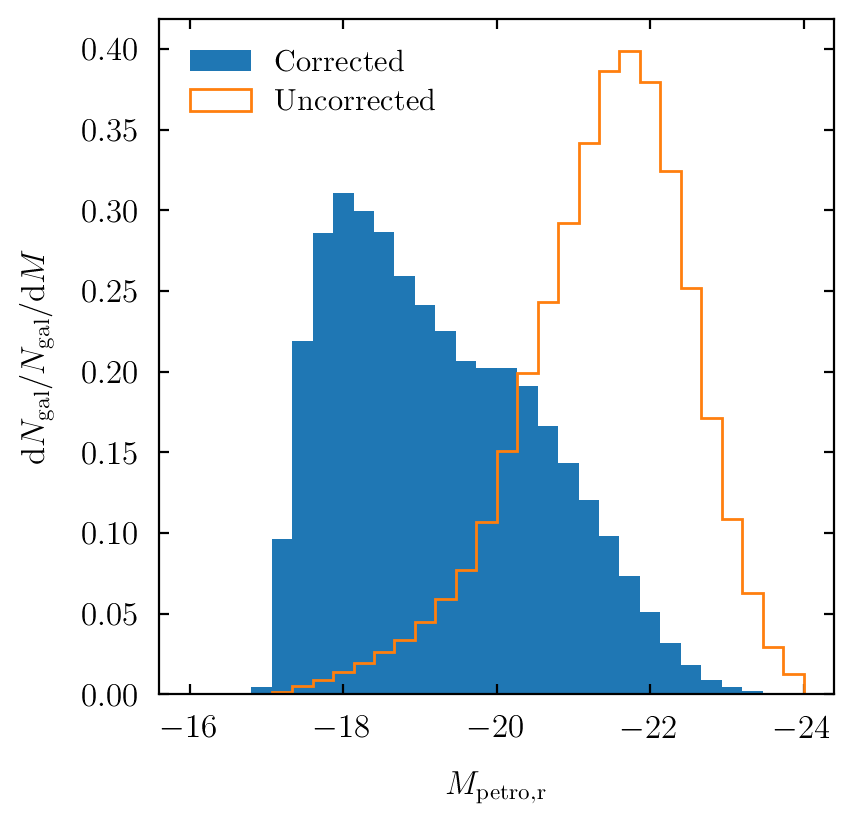

In [7]:
M = data_vmax['M_petro_r']
hist_args = dict(range = [-24.0, -16], bins = 30, density = True, log = False)

plt.figure()
plt.gca().invert_xaxis()
plt.xlabel(r'$M_{\rm petro,r}$')
plt.ylabel(r'${\rm d} N_{\rm gal} / N_{\rm gal} / {\rm d} M$')
plt.hist(M, histtype = 'stepfilled', label = r'$\mathrm{Corrected}$', weights = Vmax_inv_norm, **hist_args)
plt.hist(M, histtype = 'step', label = r'$\mathrm{Uncorrected}$', **hist_args)
plt.legend()
plt.show()

This distribution makes much more sense than the uncorrected one! Low-luminosity galaxies are intrinsically much rarer than high-luminosity ones, but the uncorrected distribution was strongly biased towards the latter.

We can now revisit our histogram of galaxy color from notebook 3, but this time weight it by $1 / V_{\rm max}$:

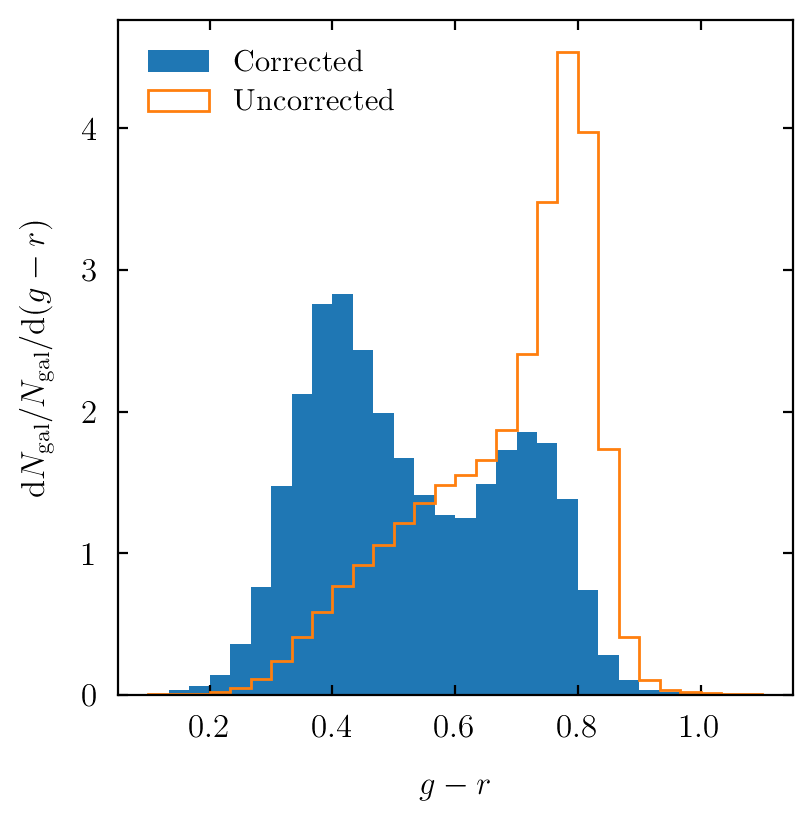

In [8]:
gr = data_vmax['color_gr']
hist_args = dict(bins = 30, range = [0.1, 1.1], density = True, log = False)

plt.figure()
plt.xlabel(r'$g-r$')
plt.ylabel(r'${\rm d} N_{\rm gal} / N_{\rm gal} / {\rm d} (g-r)$')
plt.hist(gr, histtype = 'stepfilled', label = r'$\mathrm{Corrected}$', weights = Vmax_inv_norm, **hist_args)
plt.hist(gr, histtype = 'step', label = r'$\mathrm{Uncorrected}$', **hist_args)
plt.legend()
plt.show()

The distribution has totally changed! Previously, we were dominated by red galaxies because those tend to be more massive and thus visible from farther away. Now we see a clear bimodality between "blue" and "red" galaxies that we hadn't seen before. We will revisit this bimodality at multiple points later in the course.

### 2.4.2) The Schechter luminosity function

Instead of the histogram above, we usually want to express the abundance of galaxies as a "luminosity function" in units of galaxies per volume per luminosity (or magnitude, or mass) interval.

Best fit Schechter parameters:
phi*  = 1.65e-03 Mpc^-3 dex^-1
L*    = 10^10.58 Lsun
alpha = -1.26


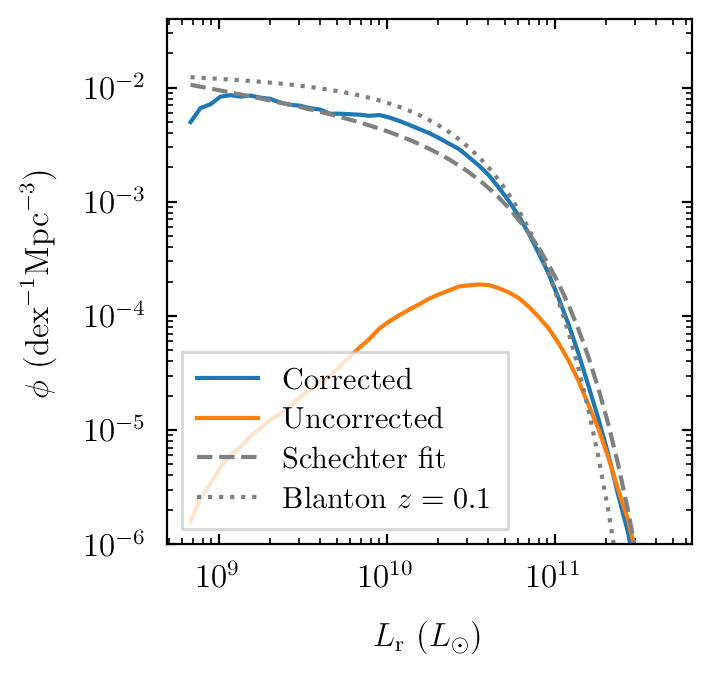

In [9]:
def schechterFunction(log_L, phi_star, log_Lstar, alpha):
    
    LLstar = 10**log_L / 10**log_Lstar
    lf = np.log(10.0) * phi_star * LLstar**(alpha + 1.0) * np.exp(-LLstar)
    
    return np.log10(lf)

# Some guess as to the survey volume
z_min_sdss = 0.001
z_max_sdss = 0.6
plot_blanton = True

# Compute luminosity in solar units. Here we add the evolution correction such that 
# magnitudes of higher-redshift galaxies are reduced to low-redshift equivalents.
M = data_vmax['M_cmodel_r'] + 1.3 * data_vmax['z']
log_L = 0.4 * (obs_utils.solar_mag['r'] - M)
L = 10**log_L

# Create luminosity function
bin_edges = np.linspace(8.8, 11.7, 50)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
dL = bin_edges[1:] - bin_edges[:-1]

# The naive calculation: compute the survey volume but do not Vmax-correct. Again,
# we could neglect the lower limit but it's easy to include in this case.
dC_max = cmn.cosmo.comovingDistance(0.0, z_max_sdss)
dC_min = cmn.cosmo.comovingDistance(0.0, z_min_sdss)
Vsdss = obs_sdss.solid_angle / 3.0 * (dC_max**3 - dC_min**3) / obs_sdss.spectroscopic_completeness
lf_biased, _ = np.histogram(log_L, bins = bin_edges)
lf_biased = lf_biased / dL / Vsdss

# The corrected calculation: instead of dividing by the survey volume, we weight
# each galaxy by its 1/Vmax.
lf_vmax, _ = np.histogram(log_L, bins = bin_edges, weights = Vmax_inv)
lf_vmax = lf_vmax / dL

# Fit with Schechter function
initial_guess = [2.5E-3, 10.5, -1.0]
params, _ = scipy.optimize.curve_fit(schechterFunction, bin_centers, np.log10(lf_vmax), 
                                     p0 = initial_guess, check_finite = True) 
fit = 10**schechterFunction(bin_centers, params[0], params[1], params[2])
print('Best fit Schechter parameters:')
print('phi*  = %.2e Mpc^-3 dex^-1' % params[0])
print('L*    = 10^%.2f Lsun' % params[1])
print('alpha = %.2f' % params[2])

# Also plot "official" SDSS fit from Blanton et al. 2003 for comparison
if plot_blanton:
    h = cmn.cosmo.h
    phi_star_b = 1.49E-2 * h**3
    Mstar_b = -20.44 + 5.0 * np.log10(h)
    log_Lstar_b = 0.4 * (obs_utils.solar_mag['r'] - Mstar_b)
    alpha_b = -1.05
    fit_blanton = 10**schechterFunction(bin_centers, phi_star_b, log_Lstar_b, alpha_b)

# Plot
plt.figure(figsize = (3.5, 3.5))
plt.xlabel(r'$L_{\rm r}\ (L_\odot)$')
plt.ylabel(r'$\phi\ ({\rm dex}^{-1} {\rm Mpc}^{-3})$')
plt.loglog()
plt.plot(10**bin_centers, lf_vmax, '-', label = r'$\mathrm{Corrected}$')
plt.plot(10**bin_centers, lf_biased, '-', label = r'$\mathrm{Uncorrected}$')
plt.plot(10**bin_centers, fit, '--', color = 'gray', label = r'$\mathrm{Schechter\ fit}$')
if plot_blanton:
    plt.plot(10**bin_centers, fit_blanton, ':', color = 'gray', label = r'$\mathrm{Blanton}\ z = 0.1$')
plt.ylim(1E-6, 4E-2)
plt.legend(frameon = True)
plt.show()

Our fit doesn't exactly match the "official" version from [Blanton et al. 2003](https://ui.adsabs.harvard.edu/abs/2003ApJ...592..819B/abstract), but that is not surprising given that they apply a much more sophisticated methodology.